<center><h1 style="background-color:#8ffaaa;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b><u>Loan Default Prediction</u></b></h1></center>
<center><img src="https://cdn.indialends.com/blog/Images/Human-Rights-Day-5-Rights-Of-A-Loan-Defaulter_banner.png",height='300',width='600'></center>

**About the Data**

This data corresponds to a set of financial transactions associated with individuals. The data has been standardized, de-trended, and anonymized. There are provided with over two hundred thousand observations and nearly 800 features.  Each observation is independent from the previous. 

**Objective**

The Objective is to determine whether a loan will default, as well as the loss incurred if it does default.

**Data Pre-processing**

Importing the libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import dataset
df = pd.read_csv('/content/drive/MyDrive/Loan prediction/train_v2.csv.zip')
df.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,...,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.72124,0.749280,...,-4.40,6,9.76,-21.82,49.18,1.0435,-0.9066,1.5883,3.4154,2.8283,2.3451,0.030594,1.7418,1.5271,0.8474,0.4715,0.028362,3.1611,2.5162,2.0037,0.019636,4.4352,4.2676,-0.1524,1,-0.40,-0.560,-0.440,-0.6280,-3.14,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,121.35,7,0.6555,0.6555,245815,0.6341,0.6341,0.3909,0.6667,0.6903,0.6903,8.449459e+08,78,50,754416.0,78.0,78.0,78.00,78.00,78.0,0.8478,0,0,0,6,0,0,0.65705,0.64069,0.626200,...,0.35,7,51.73,-72.44,798.74,2.7180,-0.8294,1.0740,2.9194,2.1180,1.5666,0.120442,1.1963,1.0322,0.4843,0.2389,0.130160,2.7659,1.9523,1.4059,0.115277,3.2763,2.7962,-0.3097,1,-0.17,-0.275,-0.203,-0.2300,-1.38,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,126.49,7,0.7542,0.7542,1385872,0.7542,0.7542,0.5508,0.7542,0.8091,0.7807,1.308478e+09,89,54,1037651.0,89.0,89.0,100.43,94.37,89.0,0.9175,0,0,0,13,0,0,0.74710,0.75878,0.654685,...,-6.35,14,56.62,-79.48,621.97,1.9592,-0.3632,3.2969,7.2072,5.7062,4.5627,0.226336,3.3277,3.4166,1.8321,0.9979,0.103307,6.8623,5.2963,4.1282,0.219729,8.1381,7.3269,-0.1909,1,-0.58,-0.540,-0.572,-0.3985,-5.18,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,133.58,7,0.8017,0.7881,704687,0.7881,0.7881,0.5923,0.7881,0.8230,0.8158,1.472752e+09,93,55,1115721.0,93.0,93.0,114.63,102.92,93.0,0.9688,0,0,0,4,0,0,0.77405,0.78929,0.750675,...,3.75,5,36.31,18.15,429.81,2.5883,-0.8812,1.2950,2.5777,2.0830,1.6899,0.054630,1.3748,1.3421,0.7982,0.4810,0.081205,2.5571,2.0593,1.6653,0.056470,3.2516,3.0631,-0.1770,1,-0.75,-0.635,-0.745,-0.5100,-2.04,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,112.77,6,0.5263,0.5263,51985,0.5263,0.5263,0.3044,0.5405,0.5556,0.5455,1.442916e+09,60,21,536400.0,60.0,60.0,60.00,60.00,60.0,0.8451,0,0,0,26,0,0,0.60315,0.53367,0.696150,...,11.45,27,2206.14,-10559.05,708436.49,9.0293,-0.8760,6.3852,17.2599,14.2795,11.9179,0.085330,7.2175,6.2262,3.1446,1.6149,0.074286,15.9080,12.5688,9.9844,0.067540,17.5561,15.6079,-0.4444,1,-0.18,-0.280,-0.182,-0.4277,-11.12,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [5]:
df.shape

(105471, 771)

In [6]:
# Check duplication in dataframe
df[df.duplicated()].shape

(0, 771)

In [7]:
# The number of each data type in the dataframe
df.dtypes.value_counts()

float64    653
int64       99
object      19
dtype: int64

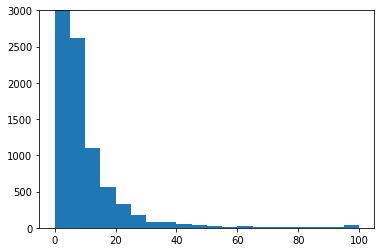

In [8]:
# Loss Distribution
fig , ax = plt.subplots()
plt.hist(df['loss'], bins = 20, range=(0,100))
ax.set_ylim([0,3000])
plt.show()

**Handling with Missing Value**

In [9]:
# Calculate percent of missing in each row
df['num_missing'] = df.isnull().sum(axis = 1)/df.shape[1]

# Drop row that percent of missing more than 20%
missing_row = df[df['num_missing'] > 0.20].index
df.drop(df.index[missing_row], inplace = True)
df.shape

(105362, 772)

In [10]:
# Drop id and num_missing collumn
df.drop(columns = ['id','num_missing'], inplace = True)

In [11]:
# Calculate percent of missing in each column
col_pct_miss = []
for col in df.columns:
    percent_miss = np.mean(df[col].isnull())*100
    if percent_miss > 0:
        col_pct_miss.append([col, percent_miss])
    
col_pct_miss_df = pd.DataFrame(col_pct_miss, columns = ['column_name','% of Missing']).sort_values(by = '% of Missing', ascending = False)
col_pct_miss_df

,column_name,% of Missing
464,f663,17.823314
463,f662,17.823314
127,f159,17.693286
128,f160,17.693286
424,f619,17.418044
...,...,...
500,f720,0.000949
501,f721,0.000949
16,f41,0.000949
474,f675,0.000949


In [12]:
# Impute missing value in numeric columns with median 
numeric_cols = df.select_dtypes(include=['number']).columns.values

for col in numeric_cols:
    if col in list(col_pct_miss_df.column_name) :
        med = df[col].median()
        df[col] = df[col].fillna(med)

In [13]:
# Impute missing value in categorical columns with mode
not_numeric_cols = df.select_dtypes(exclude=['number']).columns.values

for col in not_numeric_cols:
    if col in list(col_pct_miss_df.column_name):
        mode = df[col].mode()[0]
        df[col] = df[col].fillna(mode)

In [14]:
# Check missing value
df.isnull().sum().value_counts()

0    770
dtype: int64

**Drop Unnecessary Columns**

In [15]:
# Drop Highly Corelated Columns

# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

df.drop(columns = to_drop, inplace = True)

In [16]:
#Drop Repetitive Columns
num_rows = df.shape[0]
rep_cols = []

for col in df.loc[:, df.columns != 'loss'].columns :
    cnts = df[col].value_counts()
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.80:
        rep_cols.append([col,top_pct])
        
rep_col_df = pd.DataFrame(rep_cols, columns = ['column_name','% top repetitve value']).sort_values(by = '% top repetitve value', ascending = False).reset_index(drop=True)
rep_col_df

df.shape

(105362, 386)

**Encoding Categoricsl Columns**

As there are many attributes containing more that 20,000 categories,
we will drop those and perform binary encoding on remaining categories in each attribute.

In [17]:
cat_cols = df.select_dtypes(exclude=['number']).columns.values

drop_cols = []
keep_cols = []
for col in cat_cols:
    if df[col].value_counts().count() > 20000 : 
        print('column {} has {} categories > drop'.format(col,df[col].value_counts().count()))
        drop_cols.append(col)
    else : 
        print('column {} has {} categories > keep'.format(col,df[col].value_counts().count()))
        keep_cols.append(col)

column f137 has 6543 categories > keep
column f138 has 31145 categories > drop
column f206 has 20078 categories > drop
column f207 has 14508 categories > keep
column f276 has 6037 categories > keep
column f277 has 28706 categories > drop
column f338 has 8656 categories > keep
column f390 has 104584 categories > drop
column f391 has 104581 categories > drop
column f419 has 24803 categories > drop
column f420 has 25762 categories > drop
column f469 has 86382 categories > drop
column f472 has 102863 categories > drop
column f534 has 85343 categories > drop
column f537 has 104061 categories > drop
column f626 has 104676 categories > drop
column f627 has 104673 categories > drop
column f695 has 93660 categories > drop
column f698 has 91920 categories > drop


In [18]:
# Binary Encoding
!pip install --upgrade category_encoders
import category_encoders as ce

encoder = ce.BinaryEncoder(cols = keep_cols)
bi_enc_df = encoder.fit_transform(df[keep_cols])
bi_col_name = bi_enc_df.columns
bi_enc_df.head()

#Add Binary Encding to dataframe and drop all categorical columns
df = pd.concat([df,bi_enc_df],axis = 1)
df.head()

     |████████████████████████████████| 80 kB 5.2 MB/s 


,f1,f2,f3,f4,f5,f6,f7,f8,f13,f14,f16,f18,f19,f20,f21,f23,f25,f26,f27,f29,f31,f32,f33,f34,f35,f36,f37,f38,f39,f41,f43,f44,f45,f47,f54,f55,f57,f63,f65,f66,...,f207_4,f207_5,f207_6,f207_7,f207_8,f207_9,f207_10,f207_11,f207_12,f207_13,f207_14,f276_0,f276_1,f276_2,f276_3,f276_4,f276_5,f276_6,f276_7,f276_8,f276_9,f276_10,f276_11,f276_12,f276_13,f338_0,f338_1,f338_2,f338_3,f338_4,f338_5,f338_6,f338_7,f338_8,f338_9,f338_10,f338_11,f338_12,f338_13,f338_14
0,126,10,0.686842,1100,3,13699,7201.0,4949.0,7,0.7607,612922,0.7236,0.5171,0.7236,0.8476,1.097851e+09,66,998046.0,89.0,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.749280,0.026826,1.037424,0.83380,0.825920,2.661469,0.53855,0.551920,0.95355,0.960160,0.025156,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,121,10,0.782776,1100,3,84645,240.0,1625.0,7,0.6555,245815,0.6341,0.3909,0.6667,0.6903,8.449459e+08,50,754416.0,78.0,78.00,78.0,0.8478,0,0,0,6,0,0,0.65705,0.626200,0.107658,-0.915138,0.72515,0.687067,-0.812372,0.42545,0.393817,0.85390,0.793950,0.142922,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,126,10,0.500080,1100,3,83607,1800.0,1527.0,7,0.7542,1385872,0.7542,0.5508,0.7542,0.8091,1.308478e+09,54,1037651.0,89.0,100.43,89.0,0.9175,0,0,0,13,0,0,0.74710,0.654685,0.208224,-1.332533,0.80455,0.709346,-1.336869,0.54540,0.502138,0.88875,0.798423,0.254750,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,134,10,0.439874,1100,3,82642,7542.0,1730.0,7,0.8017,704687,0.7881,0.5923,0.7881,0.8230,1.472752e+09,55,1115721.0,93.0,114.63,93.0,0.9688,0,0,0,4,0,0,0.77405,0.750675,0.043725,-0.947279,0.81150,0.800900,-1.121228,0.58615,0.573525,0.95440,0.928550,0.067230,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,109,9,0.502749,2900,4,79124,89.0,491.0,6,0.5263,51985,0.5263,0.3044,0.5405,0.5556,1.442916e+09,21,536400.0,60.0,60.00,60.0,0.8451,0,0,0,26,0,0,0.60315,0.696150,0.062251,-0.950251,0.71780,0.810285,-0.807304,0.37220,0.483685,0.86255,0.870969,0.075199,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [19]:
# Add a 'loan_status' column where 1 represents default loan and 0 represents not default loan.
df['loan_status'] = np.where(df['loss'] > 0, 1, 0)
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f13,f14,f16,f18,f19,f20,f21,f23,f25,f26,f27,f29,f31,f32,f33,f34,f35,f36,f37,f38,f39,f41,f43,f44,f45,f47,f54,f55,f57,f63,f65,f66,...,f207_5,f207_6,f207_7,f207_8,f207_9,f207_10,f207_11,f207_12,f207_13,f207_14,f276_0,f276_1,f276_2,f276_3,f276_4,f276_5,f276_6,f276_7,f276_8,f276_9,f276_10,f276_11,f276_12,f276_13,f338_0,f338_1,f338_2,f338_3,f338_4,f338_5,f338_6,f338_7,f338_8,f338_9,f338_10,f338_11,f338_12,f338_13,f338_14,loan_status
0,126,10,0.686842,1100,3,13699,7201.0,4949.0,7,0.7607,612922,0.7236,0.5171,0.7236,0.8476,1.097851e+09,66,998046.0,89.0,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.749280,0.026826,1.037424,0.83380,0.825920,2.661469,0.53855,0.551920,0.95355,0.960160,0.025156,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,121,10,0.782776,1100,3,84645,240.0,1625.0,7,0.6555,245815,0.6341,0.3909,0.6667,0.6903,8.449459e+08,50,754416.0,78.0,78.00,78.0,0.8478,0,0,0,6,0,0,0.65705,0.626200,0.107658,-0.915138,0.72515,0.687067,-0.812372,0.42545,0.393817,0.85390,0.793950,0.142922,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,126,10,0.500080,1100,3,83607,1800.0,1527.0,7,0.7542,1385872,0.7542,0.5508,0.7542,0.8091,1.308478e+09,54,1037651.0,89.0,100.43,89.0,0.9175,0,0,0,13,0,0,0.74710,0.654685,0.208224,-1.332533,0.80455,0.709346,-1.336869,0.54540,0.502138,0.88875,0.798423,0.254750,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,134,10,0.439874,1100,3,82642,7542.0,1730.0,7,0.8017,704687,0.7881,0.5923,0.7881,0.8230,1.472752e+09,55,1115721.0,93.0,114.63,93.0,0.9688,0,0,0,4,0,0,0.77405,0.750675,0.043725,-0.947279,0.81150,0.800900,-1.121228,0.58615,0.573525,0.95440,0.928550,0.067230,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,109,9,0.502749,2900,4,79124,89.0,491.0,6,0.5263,51985,0.5263,0.3044,0.5405,0.5556,1.442916e+09,21,536400.0,60.0,60.00,60.0,0.8451,0,0,0,26,0,0,0.60315,0.696150,0.062251,-0.950251,0.71780,0.810285,-0.807304,0.37220,0.483685,0.86255,0.870969,0.075199,...,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


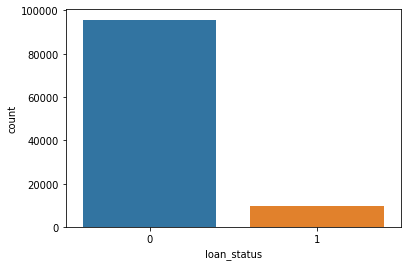

0    95584
1     9778
Name: loan_status, dtype: int64

In [20]:
# After generating a visualization from loan_status in dataframe, it was found that data is imbalanced

ax = sns.countplot(x = 'loan_status', data=df)
plt.show()

df['loan_status'].value_counts()

**Undersampling**

To balance the loan_status in dataset, undersampling technique is applied to solve imbalanced dataset problem.

In [21]:
#Resampling Data
from sklearn.utils import resample

#Seperate each target class into 2 dataframes
not_default = df[df['loan_status'] == 0]
default = df[df['loan_status'] == 1]

#Resample dataframe
resample_df_d = resample(default,
                       replace = False,
                       n_samples = 9778,
                       random_state = 1234)

resample_df_n = resample(not_default,
                       replace = False,
                       n_samples = 9778,
                       random_state = 1234)

resample_df = pd.concat([resample_df_n, resample_df_d])

**Split Train Set & Test Set**

In [22]:
from sklearn.model_selection import train_test_split

X = resample_df.drop(columns = ['loss','loan_status'])
Y = resample_df['loss']

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 0.2, random_state = 1234, stratify = resample_df['loan_status'])
print('training set = {} records, test set= {} records'.format(X_train.shape[0],X_test.shape[0]))

training set = 15644 records, test set= 3912 records


**Feature Selection - Filter Method & RFE Method**

To increase model accuracy, feature selection was done using 2 techniques.
Firstly, the less important both numerical and non-numerical features were filtered  by using filter method. Then, top 150 important numerical columns using recursive feature elimination.

In [23]:
from sklearn.feature_selection import SelectPercentile , SelectKBest, f_regression , f_classif

In [24]:
#Select top 170 important numerical columns with filter method
X_train_num = X_train.drop(columns = bi_col_name)

selector = SelectKBest(score_func = f_regression, k = 170)
selector.fit(X_train_num,Y_train)

select_cols = selector.get_support(indices = True)
select_num_cols = X_train_num.iloc[:,select_cols]

select_num_col_name = select_num_cols.columns
select_num_cols.head()

,f1,f7,f8,f13,f14,f18,f19,f20,f21,f25,f26,f27,f29,f31,f32,f39,f45,f55,f63,f65,f67,f68,f69,f70,f75,f76,f77,f80,f82,f84,f85,f89,f90,f94,f99,f100,f104,f109,f112,f113,...,f402,f404,f405,f406,f412,f413,f425,f441,f442,f448,f450,f456,f471,f514,f516,f524,f530,f536,f541,f556,f589,f596,f600,f612,f613,f618,f620,f621,f629,f631,f640,f654,f670,f674,f677,f715,f734,f737,f775,f776
27782,157,3344.0,359.0,13,0.8761,0.8534,0.7082,0.8761,0.8919,97,1519155.0,165.24,185.91,99.0,1.0000,0.73670,0.78595,0.54410,0.91000,0.676717,11.0278,13,0.05,0.02,6.51,6.12,6.37,1.11,0.01,0.10,327.0,0.30,1.38,0.10,0.30,1.38,0.11,0.31,0.01,0.00,...,0.000,0.435,0.189,0.542424,-0.470118,1.127558,6.5497,6.3876,7.045,1.3731,6.2336,114624460.0,1.13,89.076,6.675,6.9917,25271446,1.20,4844.0,1.18,0.0043,5.300,-0.21,2.102284,-0.13,0.12,-0.03,-0.03,0.4300,0.61381,73.112,19.97,1195,34,9.0,18784151.89,6.82,3.110,-0.4947,0
95214,129,3967.0,1900.0,10,0.8957,0.8879,0.6943,0.9035,0.9035,78,1241253.0,103.00,126.96,103.0,0.9364,0.77395,0.82175,0.63715,0.92820,0.905300,7.8578,10,0.07,0.09,5.32,6.45,6.94,0.93,0.26,0.08,337.0,0.28,1.44,0.08,0.27,1.47,0.08,0.28,0.26,0.09,...,0.390,0.515,0.623,0.429333,0.963347,1.242589,7.1880,7.4955,4.425,1.0766,6.4896,126904350.0,1.18,104.514,5.545,6.1910,1043620319,1.15,166194.0,1.16,0.0173,6.170,0.26,1.488537,-0.20,0.24,-0.02,0.01,0.4950,0.51160,97.960,35.08,844,18,4.0,14440369.86,1.87,-2.355,0.9484,0
103233,132,1804.0,1086.0,8,0.7869,0.7680,0.6039,0.8067,0.8496,77,1188864.0,96.00,118.33,96.0,0.9697,0.79400,0.86480,0.62195,0.97485,0.953425,6.9392,8,0.02,0.02,9.22,9.81,7.35,0.93,0.01,0.07,119.0,0.25,1.50,0.07,0.25,1.50,0.08,0.27,0.01,0.00,...,0.138,0.310,0.334,0.406250,1.021270,1.348079,3.7775,7.9641,5.040,1.1188,7.2497,7390780.0,1.20,97.422,4.320,6.4315,482229563,1.09,44714.0,1.13,0.0151,3.610,-0.50,1.558799,-0.36,0.63,-0.04,0.01,0.1390,0.23450,98.562,29.41,577,11,8.0,9785064.75,4.56,3.690,0.9931,0
78693,158,53.0,860.0,6,0.0000,0.0000,0.5719,0.0000,0.0000,0,1235676.0,0.00,0.00,89.0,0.0000,0.30000,0.42000,0.48595,0.44000,0.672307,2.3940,5,0.03,0.02,5.49,2.23,7.43,0.74,0.51,0.06,3.0,0.23,1.57,0.11,0.32,1.34,0.04,0.19,0.52,0.90,...,0.629,0.480,0.536,0.512381,0.754120,1.255171,7.3995,8.1985,5.530,0.6665,7.4931,111.0,1.11,87.590,6.120,6.6366,198276230,1.10,20532.0,1.15,0.0164,2.935,0.30,1.296513,0.04,0.02,0.02,0.03,0.6445,0.62346,83.331,33.34,426,44,1.0,266370.32,10.53,8.675,0.6809,1
84625,133,4594.0,6357.0,6,0.8583,0.8306,0.6488,0.8512,0.9115,85,1336734.0,103.00,103.00,103.0,1.0000,0.78530,0.86575,0.59440,0.97000,0.932900,5.2197,6,0.06,0.05,6.43,8.43,6.15,1.05,0.07,0.13,577.0,0.33,1.31,0.12,0.32,1.34,0.10,0.30,0.07,0.00,...,0.000,0.205,0.163,0.322857,0.569093,1.093944,5.2300,6.1775,4.290,1.0900,5.3842,513660035.0,1.15,84.654,4.580,5.4244,46664067228,1.15,2717148.0,1.16,0.2316,2.370,-0.18,1.535453,-0.27,1.86,-0.19,-0.12,0.1500,0.35029,89.730,44.25,472,10,6.0,10918027.76,6.25,3.035,-0.5100,0


In [ ]:
#Select top 150 important numerical columns with RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

selector = RFE(LogisticRegression(), n_features_to_select=150, step=1, verbose = 2)
selector = selector.fit(select_num_cols, Y_train)
select_cols = selector.get_support(indices = True)
select_cols_df = select_num_cols.iloc[:,select_cols]

best_X_col_name = select_cols_df.columns
select_cols_df.head()

Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.


In [ ]:
# Select top 5 important categorical columns with filter method

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

X_train_cat = X_train.select_dtypes(exclude = 'number').copy()

# Create encoder
le = LabelEncoder()
X_train_cat = X_train_cat.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

# Prepare input data 
oe = OrdinalEncoder()
oe.fit(X_train_cat)
X_train_cat_enc = oe.transform(X_train_cat)

selector = SelectKBest(score_func = f_classif , k=5)
selector.fit(X_train_cat_enc,Y_train)

select_cols = selector.get_support(indices = True)
select_cat_cols = X_train_cat.iloc[:,select_cols]

select_cat_col_name = select_cat_cols.columns
select_cat_cols.head()

In [ ]:
#Combine categorical and non-categorical dataframe together
def filter_x_df(x):
    df = x.copy()
    all_filter_col = []
    
    for keep in select_cat_col_name[select_cat_col_name.isin(keep_cols)]:
        filter_col = [col for col in df.columns if col.startswith(str(keep))]
        for col in filter_col : 
            if col not in keep_cols:
                all_filter_col.append(col)
        
    drop_cat_df = df.drop(columns = cat_cols)
    
    new_df = pd.concat([drop_cat_df[best_X_col_name],drop_cat_df[all_filter_col]],axis = 1)
    return new_df

In [ ]:
# Create filter_X_train and filter_X_test dataframe 
# Apply filter_x_df function to X_train and X_test

filter_X_train = filter_x_df(X_train)
filter_X_test = filter_x_df(X_test)

In [ ]:
filter_X_train.head()

**Data Standardization**

In [ ]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()  
scaler.fit(filter_X_train)

X_train_scal = scaler.fit_transform(filter_X_train)
X_test_scal = scaler.fit_transform(filter_X_test)

**K-nearest neighbors**

In [31]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier()
neigh.fit(X_train_scal, Y_train)

Knn_y_pred_train =  neigh.predict(X_train_scal)
Knn_y_pred_test =  neigh.predict(X_test_scal)

scores_kn = cross_val_score(estimator = neigh, y = Y_train, X = X_train_scal, cv=5)
print('Cross Validation Score:', np.mean(scores_kn))

Cross Validation Score: 0.4618382894447537


**Logistic Regression**

In [32]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr = logisticRegr.fit(X_train_scal, Y_train)

Lr_y_pred_train = logisticRegr.predict(X_train_scal)
Lr_y_pred_test = logisticRegr.predict(X_test_scal)

scores_lr = cross_val_score(estimator = logisticRegr, y = Y_train, X = X_train_scal, cv=5)
print('Cross Validation Score:', np.mean(scores_lr))

Cross Validation Score: 0.4919455322251457


Random Foreset

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 70)
rf.fit(filter_X_train, Y_train)

rf_y_pred_train =  rf.predict(filter_X_train)
rf_y_pred_test =  rf.predict(filter_X_test)

scores_rf = cross_val_score(estimator = rf, y = Y_train, X = filter_X_train, cv=5)
print('Cross Validation Score:', np.mean(scores_rf))

Cross Validation Score: 0.4980822501162706


**XGboost**

In [ ]:
from  xgboost import XGBClassifier

xgb = XGBClassifier(gamma=0, learning_rate=0.1, max_depth=100, n_estimators=100)
xgb.fit(filter_X_train,Y_train)

xgb_y_pred_train = xgb.predict(filter_X_train)
xgb_y_pred_test = xgb.predict(filter_X_test)

scores_xg = cross_val_score(estimator = rf, y = Y_train, X = filter_X_train, cv=5)
print('Cross Validation Score:', np.mean(scores_xg))

# Conclusion

After using k-fold cross validation to evaluate the models, it was found that Random Forest gives the highest scores in predicting loan default, but it is not significantly different from XGboost and Logistic Regression scores.

